# Penarikan Data (Data Collecting)

Data yang digunakan untuk analisa berasal dari https://sectors.app/. Untuk melakukan penarikan datanya menggunakan API Key yang telah disimpan kedalam file **.env**. Tujuan menggunakan **.env** adalah agar API Key kita aman dan tidak terlihat langsung dalam kode.

In [1]:
from dotenv import load_dotenv
import os

Gunakan `load_dotenv()` untuk memuat semua variabel dari file .env kita.

In [2]:
load_dotenv()

True

Kemudian ambil key tersebut dari environment dan simpan dalam variabel. Gunakan `os.getenv("NAMA_VARIABEL")` untuk mengambil nilai dari variabel tersebut.

In [3]:
SECTORS_API_KEY = os.getenv("SECTORS_API_KEY")

Agar lebih mudah, alamat utama API dan header otorisasi disimpan kedalam variabel. Sehingga, tidak perlu mengetiknya berulang kali.

In [4]:
BASE_URL = "https://api.sectors.app/v1"
HEADERS = {"Authorization": SECTORS_API_KEY}

> Penjelasan :
- `BASE_URL` menyimpan alamat utama API, 
- `HEADERS` menyimpan API Key yang akan dikirim saat kita melakukan permintaan ke API.

## Extracting and Loading Financial Data

Tidak semua data di https://sectors.app digunakan untuk analisa. Untuk analisa kali ini hanya menggunakan data subsektor industri dan daftar perusahaan dari subsektor `Food Beverage`. Gunakan perintah import '`requests`' yang berfungsi sebagai "kurir" untuk mengirim permintaan kita.  

In [5]:
import requests

### Subsectors

Tentukan alamat lengkap pesanan kita berdasarkan dokumentasi. Gunakan `f"{...}"` untuk mempermudah menggabungkan string di Python.

In [6]:
## BASE_URL/subsectors/
url_subsectors = f"{BASE_URL}/subsectors/"

In [7]:
url_subsectors

'https://api.sectors.app/v1/subsectors/'

Kemudian kirim permintaannya :
- Gunakan `requests.get()` adalah perintah untuk "Merequest ambilkan data dari URL".
- Gunakan `HEADERS` agar server mengetahui siapa yang merequest data yang diinginkan.

In [8]:
resp = requests.get(url_subsectors, headers=HEADERS)
resp

<Response [200]>

> Penjelasan :
- `<Response [200]>` berarti request untuk penarikan data berhasil.
- `resp` adalah jawaban dari server. Untuk melihat isinya dalam format yang dapat dibaca oleh Python, maka gunakan `.json()`.

In [9]:
resp.json()


[{'sector': 'transportation-logistic', 'subsector': 'transportation'},
 {'sector': 'infrastructures', 'subsector': 'telecommunication'},
 {'sector': 'infrastructures',
  'subsector': 'heavy-constructions-civil-engineering'},
 {'sector': 'properties-real-estate', 'subsector': 'properties-real-estate'},
 {'sector': 'consumer-non-cyclicals', 'subsector': 'food-beverage'},
 {'sector': 'infrastructures', 'subsector': 'utilities'},
 {'sector': 'healthcare', 'subsector': 'healthcare-equipment-providers'},
 {'sector': 'financials', 'subsector': 'financing-service'},
 {'sector': 'consumer-non-cyclicals', 'subsector': 'tobacco'},
 {'sector': 'healthcare', 'subsector': 'pharmaceuticals-health-care-research'},
 {'sector': 'consumer-non-cyclicals',
  'subsector': 'nondurable-household-products'},
 {'sector': 'consumer-cyclicals', 'subsector': 'media-entertainment'},
 {'sector': 'industrials', 'subsector': 'industrial-goods'},
 {'sector': 'consumer-non-cyclicals', 'subsector': 'food-staples-retailin

Kemudian ubah menjadi `DataFrame` agar mudah untuk dianalisis:

In [10]:
import pandas as pd

subsectors_df = pd.DataFrame(resp.json())
subsectors_df.head()

,sector,subsector
0,transportation-logistic,transportation
1,infrastructures,telecommunication
2,infrastructures,heavy-constructions-civil-engineering
3,properties-real-estate,properties-real-estate
4,consumer-non-cyclicals,food-beverage


### Companies

Selanjutnya, mengambil daftar perusahaan berdasarkan subsektor. Kita akan melihat perusahaan di subsektor **Food Beverage**:

In [11]:
## url daftar perusahaan
url_companies = f"{BASE_URL}/companies/"

In [12]:
url_companies

'https://api.sectors.app/v1/companies/'

In [13]:
selected_subsector = "food-beverage"

Karena kita memilih daftar perusahaan yang ada di `food-beverage` maka perlu ditambahkan "catatan khusus" pada request kita. Maka, gunakan '`params`' (parameter). 

In [14]:
params = {"sub_sector" : selected_subsector}

In [15]:
# kirim request
resp = requests.get(url_companies, headers=HEADERS, params=params)

In [16]:
resp

<Response [200]>

Ubah kedalam `dataframe`

In [17]:
companies_df = pd.DataFrame(resp.json())
companies_df.head()

,symbol,company_name,sorted_by
0,AALI.JK,Astra Agro Lestari Tbk,AALI.JK
1,ADES.JK,Akasha Wira International Tbk Tbk,ADES.JK
2,AGAR.JK,PT Asia Sejahtera Mina Tbk,AGAR.JK
3,AISA.JK,PT FKS Food Sejahtera Tbk,AISA.JK
4,ALTO.JK,Tri Banyan Tirta Tbk,ALTO.JK


# Pemanfaatan AI

Pada tahap di atas kita telah melakukan proses pengambilan data menggunakan API. Kemudian langkah selanjutnya adalah 
- Gunakan  **AI (Large Language Model)** untuk membaca dan menginterpretasi data keuangan.
- Gunakan **LangChain**. Langchain adalah framework Python yang memudahkan kita dalam:
    * Menyusun prompt
    * Menghubungkan LLM dengan data kita
    * Menyusun pipeline otomatis dari input hingga output
- Gunakan **Groq**. Groq adalah layanan yang menyediakan akses ke model-model LLM super cepat seperti LLaMA 3 dan lainnya. Kita akan menggunakan Groq sebagai penyedia model AI-nya.

## Setting Up LangChain and LLMs

Sebelum memulainya, perlu untuk mengimpor dua komponen penting : 

* `langchain_groq`: digunakan untuk menghubungkan LangChain dengan model LLM dari Groq.
* `PromptTemplate`: digunakan untuk membuat format pertanyaan atau instruksi yang ingin kita berikan ke AI.

In [18]:
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate

## Inisialisasi Model LLM

Sebelum menggunakan LLM, kita perlu menginisiasi model yang akan digunakan.

Tentukan 3 parameter utama:
* `groq_api_key`: API Key dari Groq yang disimpan kedalam file `.env`. Digunakan untuk otorisasi.
* `model_name`: nama model yang ingin digunakan. Kita menggunakan model `"llama3-70b-8192"`, yaitu model besar dan canggih dari Meta yang disediakan Groq.
* `temperature`: mengatur tingkat kreativitas jawaban.

  * Semakin **rendah** (misalnya 0.0) → jawaban lebih konsisten dan deterministik.
  * Semakin **tinggi** (misalnya 1.0) → jawaban lebih kreatif dan bervariasi.
  * Kita menggunakan `0.8` agar hasilnya tetap kreatif namun tidak terlalu liar.


In [19]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [20]:
llm = ChatGroq(
    groq_api_key = GROQ_API_KEY,
    temperature=0.8,
    model_name="llama-3.3-70b-versatile"
)

In [21]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021BC7DD0A70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021BC80B1910>, model_name='llama-3.3-70b-versatile', temperature=0.8, model_kwargs={}, groq_api_key=SecretStr('**********'))

## Creating an Automated Financial Summary

### Step 1: Mengambil Data Kuartalan

Kita akan mengambil data laporan keuangan dari 6 kuartal terakhir (dari `2024-03-31` sampai dengan `2025-06-30`). Data ini akan menjadi **bahan bacaan** untuk AI yang telah kita buat. Ambil data laporan keuangan 6 kuartal terakhir untuk simbol yang sama.

In [22]:
symbol = "SGRO.JK"
url_fin = f"{BASE_URL}/financials/quarterly/{symbol}/"
params = {"n_quarters" : "6",
          "report_date": "2024-03-31"}

In [23]:
response = requests.get(url_fin, headers=HEADERS, params=params)
financials = pd.DataFrame(response.json())

In [24]:
financials

,symbol,financials_sector_metrics,date,premium_income,premium_expense,net_premium_income,non_interest_income,revenue,operating_expense,provision,...,cash_and_short_term_investments,non_loan_assets,total_current_asset,total_non_current_liabilities,financing_cash_flow,operating_cash_flow,investing_cash_flow,net_cash_flow,capital_expenditure,free_cash_flow
0,SGRO.JK,None,2025-06-30,None,None,None,7725000000,-1677319706148,-130326780408,None,...,702302,None,1925530,2422014,471396158958,-322597085766,99305788504,248104861696,-135277702408,-187319383358
1,SGRO.JK,None,2025-03-31,None,None,None,9267000000,1677323000000,130327000000,None,...,592564000000,None,2019167000000,2484785000000,-471397000000,322598000000,-99306000000,-248105000000,135278000000,187320000000
2,SGRO.JK,None,2024-12-31,None,None,None,24584000000,2208740000000,111772000000,None,...,840602000000,None,2224658000000,2731943000000,-207432000000,782001000000,-156709000000,417860000000,297135000000,484866000000
3,SGRO.JK,None,2024-09-30,None,None,None,4509000000,1216719000000,92499000000,None,...,422621000000,None,1756989000000,2745747000000,-14699000000,154276000000,-152128000000,-12551000000,156870000000,-2594000000
4,SGRO.JK,None,2024-06-30,None,None,None,4870000000,1134862000000,91733000000,None,...,435209000000,None,1661490000000,2624951000000,102773000000,-15293000000,-107114000000,-19634000000,123169000000,-138462000000
5,SGRO.JK,None,2024-03-31,None,None,None,6286000000,1133907000000,115977000000,None,...,454837000000,None,1671471000000,2979191000000,-317654000000,334788000000,-98274000000,-81140000000,150570000000,184218000000


### Step 2: Prompt Template untuk Ringkasan Keuangan

Buat prompt template yang lebih spesifik untuk memandu AI memberikan ringkasan dari laporan keuangan. Kemudian berikan AI sebuah peran (sebagai analis saham) dan instruksi yang jelas (fokus pada harga saham terakhir saat penutupan, laba berjalan, nilai ROE).

In [25]:
prompt_summary_template = PromptTemplate.from_template(

    """
    Anda adalah seorang analis keuangan yang sangat pintar.
    Berdasarkan data keuangan kuartalan berikut (dalam jutaan Rupiah):

    {data}

    Tuliskan ringkasan eksekutif berdasarkan poin dibawah ini.
    Fokus pada:

    1. Analisis Tren Waktu
    - Pertumbuhan : Revenue, Net Premium Income, Operating Expense, Net Cash Flow.
    - Profitabilitas : Laba kotor, laba operasi, laba bersih (kalau tersedia).

    2. Rasio Keuangan Utama
        Profitability :
        - Net Margin = (Revenue - Operating Expense - Provision) / Revenue.
        - ROA = Net Income / Total Assets.
        - ROE = Net Income / Equity (kalau ada equity).

        Liquidity :
        - Current Ratio = Total Current Asset / Total Non-Current Liabilities.
        - Cash Ratio = Cash and Short-Term Investments / Total Current Asset.

        Efficiency :
        - Expense Ratio = Operating Expense / Revenue.
        - Combined Ratio (khusus asuransi) = (Premium Expense + Operating Expense) / Premium Income.

    3. Arus Kas
    - Analisis Operating vs Investing vs Financing Cash Flow : apakah perusahaan menghasilkan kas dari operasi atau bergantung dari utang/pendanaan.
    - Free Cash Flow = Operating Cash Flow - Capital Expenditure.
    - Net Cash Flow Trend : apakah cadangan kas tumbuh atau berkurang.

    4. Health Check
    - Bandingkan antar periode (QoQ, YoY).
    - Cek apakah perusahaan:
        - Sustainable : pendapatan tumbuh, beban terkendali.
        - Likuid : punya kas cukup untuk jangka pendek.
        - Efisien : Opex tidak lebih cepat tumbuh dari pendapatan.
        - Sehat dari sisi cashflow : Operating CF positif secara konsisten.

    5. Forecasting
    - Forecast Revenue & Cash Flow : gunakan regresi atau ARIMA.
    - Scenario analysis : misalnya dampak kenaikan Opex 10% ke net cash flow.
    
    """
)

In [26]:
## Eksekusi dan hasilkan ringkasan dari LLM:

prompt_summary = prompt_summary_template.format(data = financials)
print(llm.invoke(prompt_summary).content)

Berikut adalah ringkasan eksekutif berdasarkan data keuangan kuartalan yang disediakan:

**Analisis Tren Waktu**

* Pertumbuhan: 
 + Revenue mengalami fluktuasi, dengan penurunan signifikan di Q2 2025.
 + Net Premium Income tidak tersedia karena nilai premium_income dan premium_expense tidak ada.
 + Operating Expense meningkat secara signifikan di Q2 2025.
 + Net Cash Flow mengalami fluktuasi, dengan penurunan signifikan di Q2 2025.
* Profitabilitas: 
 + Laba kotor, laba operasi, dan laba bersih tidak dapat dihitung karena kurangnya data.

**Rasio Keuangan Utama**

* Profitability: 
 + Net Margin tidak dapat dihitung karena kurangnya data.
 + ROA dan ROE tidak dapat dihitung karena kurangnya data.
* Liquidity: 
 + Current Ratio meningkat secara signifikan di Q2 2025 karena penurunan Total Non-Current Liabilities.
 + Cash Ratio meningkat secara signifikan di Q2 2025 karena penurunan Total Current Asset.
* Efficiency: 
 + Expense Ratio meningkat secara signifikan di Q2 2025.
 + Combined 

### Step 3: Visualizing Trends

In [27]:
# ambil data yang relevan untuk di buat chart
sample_data_viz = financials[['date','revenue', 'operating_expense', 'net_cash_flow']]
sample_data_viz.head()

,date,revenue,operating_expense,net_cash_flow
0,2025-06-30,-1677319706148,-130326780408,248104861696
1,2025-03-31,1677323000000,130327000000,-248105000000
2,2024-12-31,2208740000000,111772000000,417860000000
3,2024-09-30,1216719000000,92499000000,-12551000000
4,2024-06-30,1134862000000,91733000000,-19634000000


Prompt Template untuk Visualisasi:

In [28]:
template_viz = PromptTemplate.from_template(
    """
    
    Anda adalah seorang programmer Python yang ahli dalam visualisasi data.

    Berikut adalah data revenue, operating_expense, dan net_cash_flow perusahaan:

    {data}

    Buat sebuah skrip Python menggunakan matplotlib untuk menghasilkan line plot. 
    Instruksi:
    - Sumbu X adalah 'date' dan di urutkan dari periode awal sampai periode terakhir
    - Sumbu Y adalah 'revenue', 'operating_expense', dan 'net_cash_flow'
    - Dibuat dalam 1 chart dan berikan warna yang berbeda revenue : biru, operating_expense : merah, net_cash_flow : hijau
    - Berikan poin di sumbu y nya 
    - Berikan nilai y dalam miliar rupiah pada masing-masing line
    - Buat semua dalam bentuk line bukan garis putus-putus
    - Untuk sumbu x di rotasi 45 derajat
    - PENTING: Simpan plot ke dalam variabel bernama `fig`. Contoh: `fig, ax = plt.subplots()`
     
    Tulis HANYA kode Python yang bisa langsung dieksekusi. Jangan sertakan penjelasan apapun.

    """
)

Kemudian request LLM untuk menghasilkan kodenya:

In [29]:
llm_viz = llm.invoke(template_viz.format(data=sample_data_viz)).content

# bersihkan stip ```python
clean_code = llm_viz.strip().strip("```python").strip() 
print(clean_code)

import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'date': ['2025-06-30', '2025-03-31', '2024-12-31', '2024-09-30', '2024-06-30', '2024-03-31'],
    'revenue': [-1677319706148, 1677323000000, 2208740000000, 1216719000000, 1134862000000, 1133907000000],
    'operating_expense': [-130326780408, 130327000000, 111772000000, 92499000000, 91733000000, 115977000000],
    'net_cash_flow': [248104861696, -248105000000, 417860000000, -12551000000, -19634000000, -81140000000]
}

# Buat DataFrame
df = pd.DataFrame(data)

# Urutkan data berdasarkan tanggal
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Buat plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df['date'], df['revenue']/1e9, label='revenue', color='blue', marker='o')
ax.plot(df['date'], df['operating_expense']/1e9, label='operating_expense', color='red', marker='o')
ax.plot(df['date'], df['net_cash_flow']/1e9, label='net_cash_flow', color='green', marker='o')

# Atur sumbu x
plt.xticks(

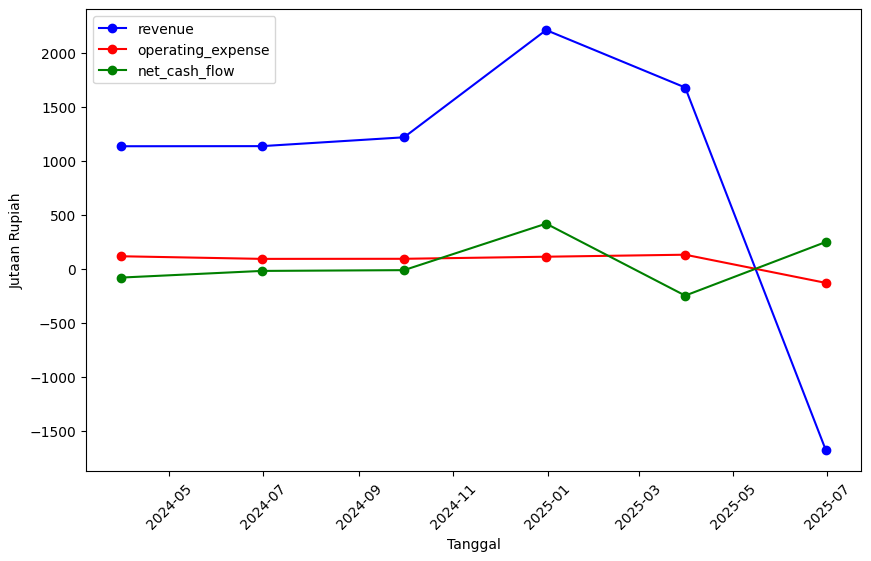

In [30]:
# Untuk menjalankan suatu kode yang berbentuk string gunakan fungsi `exec()`
exec(clean_code)

### Step 4: Interpreting Key Financial Trends

Kita minta LLM untuk menganalisis tren dari data revenue, operating_expense, dan net_cash flow.

In [31]:
template_trend = PromptTemplate.from_template(
    """
    Anda adalah seorang analis keuangan yang hebat.
    Berdasarkan data kuartalan berikut:
    {data}
    Analisis tren utama yang muncul dari data tersebut. Fokus pada pergerakan revenue, operating_expense, dan net_cash_flow.
    Sajikan analisis dalam 3 poin. Tuliskan dalam bahasa yang singkat, padat, jelas, dan mudah untuk dapat dipahami.
    
    """
)

In [32]:
interpretasi_tren = llm.invoke(template_trend.format(data=financials))
print(interpretasi_tren.content)

Berikut adalah analisis tren utama dari data keuangan:

1. **Reveneu**: Reveneu perusahaan mengalami fluktuasi, namun terdapat peningkatan pada beberapa kuartal. Pada kuartal 2024-12-31, reveneu mencapai 2.208.740.000.000, yang merupakan nilai tertinggi dalam data tersebut.
2. **Operating_expense**: Biaya operasional perusahaan juga mengalami fluktuasi, namun cenderung meningkat. Pada kuartal 2025-06-30, biaya operasional mencapai -130.326.780.408, yang merupakan nilai terendah dalam data tersebut.
3. **Net_cash_flow**: Arus kas neto perusahaan mengalami perubahan yang signifikan, dengan nilai positif pada beberapa kuartal dan nilai negatif pada kuartal lainnya. Pada kuartal 2024-12-31, arus kas neto mencapai 417.860.000.000, yang merupakan nilai tertinggi dalam data tersebut.


### Step 5: Detecting Potential Financial Risks

Kita juga bisa meminta LLM untuk mencari potensi risiko yang mungkin tersembunyi dalam laporan keuangan `SGRO.JK`. Mari kita suruh AI untuk menjadi "skeptis" dan mencari potensi masalah.

In [33]:
template_risk = PromptTemplate.from_template(
    """
    Anda adalah seorang analis risiko keuangan yang skeptis.
    Periksa data keuangan berikut dengan teliti:

    {data}
    
    Indentifikasi 1 sampai 3 potensi risiko atau "red flags" yang perlu diwaspadai dari data tersebut. 
    Jelaskan dalam satu kalimat singkat, padat, jelas dan mudah untuk dipahami.

    """
)

In [34]:
llm_risiko = llm.invoke(template_risk.format(data=financials))
print(llm_risiko.content)

Beberapa potensi risiko yang perlu diwaspadai dari data tersebut adalah adanya nilai-nilai yang tidak konsisten dan tidak masuk akal seperti "None" pada beberapa kolom, nilai pendapatan dan biaya yang sangat besar dan tidak stabil, serta perubahan arah cash flow yang tidak wajar.
